In [1]:
import os
from sunscc.nb.load import load_from_dir, load_from_dir2, load_from_dir_new_pl, load_from_cfg
from pathlib import Path
from astropy.io import fits
import skimage.io as io
import numpy as np
import torch 
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib ipympl

from sunscc.dataset import DeepsunSegmentationPredictDataset, get_grid_size, crop_patch
from sunscc.dataset.utils import *
from sunscc.callback import reconstruct_segmentation_image, display_classification_predictions

### Set environment variable and path to the image to be processed

In [2]:
cwd = Path(os.getcwd())
tmp = cwd.parents[0]
os.environ['SUNSCCDATASET_PATH'] = str(tmp)
print(os.environ['SUNSCCDATASET_PATH'])

input_image = "./UPH20240510080302.FTS"
output_dir = Path('./predictions')

/Users/nielssayez/SunSCC


# Segmentation

### Define path to Segmentation model and load it.

In [3]:
# segmenter_run_dir = Path(os.environ['SUNSCCDATASET_PATH']+'/outputs/2024-05-08/16-20-50_2013-15_UNet_T375_StepLR_epoch_1_run0')
# segmenter_run_dir = Path(os.environ['SUNSCCDATASET_PATH']+'/outputs/2023-01-22/13-15-38_2013-15_UNet_T425_T375_T325_StepLR_epoch_1_run8_SUNSCC')
segmenter_run_dir = Path('/Volumes/WB_EXT_Niels/ROB_SEMINAR/Models/Segmentation/seg_run0')


In [4]:
dataset_overrides = [
        'dataset.test_dataset.transforms=[]', 
    ]
seg_config, seg_model, seg_dm, seg_trainer = load_from_dir_new_pl(
                                    run_path= segmenter_run_dir.resolve(),
                                    # run_path= run_dir,
                                    load_trainer=False,
                                    override = dataset_overrides + [
                                        # Don't create new wandb run when testing/predicting
#                                         f'logger=[{{_target_: pytorch_lightning.loggers.CSVLogger, save_dir: "csv_metrics"}}]',
                                        '~callbacks.LR_monitor',
                                        '~callbacks.wandb',
                                    ]
                                )
# dm.setup()
test_dataloader = seg_dm.test_dataloader()

/Users/nielssayez/SunSCC/sunscc/nb/load.py:159: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(config_dir=str(config_path.parents[0])):
Lightning automatically upgraded your loaded checkpoint from v1.6.0 to v2.2.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../Volumes/WB_EXT_Niels/ROB_SEMINAR/Models/Segmentation/seg_run0/models/last.ckpt`


BaseSegment
{'_target_': 'sunscc.model.ConfUnet', 'model_cfg': {'_target_': 'sunscc.model.ModelConfig'}, 'architecture': {'first': 32, 'enc': {'width': [32, 64, 128, 256, 512, 512, 512], 'repeat': [1, 1, 1, 1, 1, 1, 1]}, 'dec': {'width': [512, 512, 256, 128, 64, 32], 'repeat': [1, 1, 1, 1, 1, 1]}}, 'input_format': ['image'], 'output_format': ['segmentation'], 'classes': ['sunspot'], 'block': 'double'}
sunscc.loss.CombineLosses
Ignored_indexA: -100  Ignored_indexB: None
['sunspot']


/Users/nielssayez/opt/miniconda3/envs/sunscc/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 10 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Load input image, split it in a grid and create a batch for segmentation model

In [5]:
hdulst:fits.HDUList = fits.open(input_image)
image = hdulst[0]
header = image.header
center = np.array(image.shape)//2
radius = header['SOLAR_R']

patch_side = test_dataloader.dataset.patch_side
grid_size = get_grid_size(input_image, patch_side)

batch_v1 = {}

for index in tqdm(range(grid_size)):

    sample = {} 
    idx_img = index // grid_size
    idx_patch = index % grid_size

    sample["image"] = crop_patch((image.data).astype(float), idx_patch, patch_side, grid_size) # load image from directory with skimage
    sample['sample_id'] = f'{idx_img}_{idx_patch}'
    sample["name"] = os.path.basename(input_image)

    sample["segmentation"] = np.zeros_like(sample["image"])
    
    batch_v1[idx_patch] = sample

hdulst.close()

  0%|          | 0/16 [00:00<?, ?it/s]

### Predict the segmentation masks, reconstruct complete image, write on disk

In [6]:
keys_to_tensor = ['image', 'segmentation']

batch_v2 = {key: torch.tensor(np.concatenate([d[key][None,:,:] for d in batch_v1.values()])) 
            if key in keys_to_tensor else [d[key] for d in batch_v1.values()] 
            for key in batch_v1[0].keys()}

output_seg = seg_model.predict(batch_v2)
reconstruct_segmentation_image(grid_size, batch_v2, output_seg, output_dir)

###  Load segmentation mask and show

In [7]:
seg_mask_fn = output_dir/(os.path.basename(input_image).split(".")[0]+ ".png")
seg_mask = io.imread(seg_mask_fn)

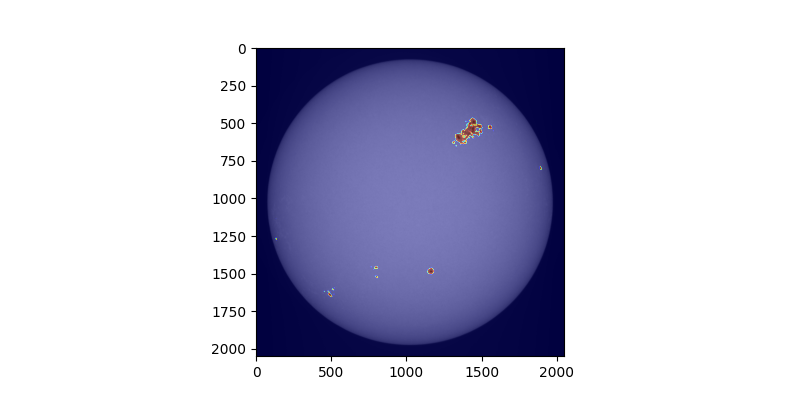

In [8]:
fig  = plt.figure(figsize=(8,4))
ax1 = plt.subplot(1, 1, 1)
ax1.imshow(image.data, cmap='gray', interpolation=None)
ax1.imshow(seg_mask, cmap='jet', alpha=0.5 )



# Clustering

In [9]:
import sunscc.utils.clustering.clustering_utilities as c_utils

### Define clustering parameters and find sunspots groups in image

In [10]:
wl_fn , seg_mask_fn = input_image, seg_mask_fn

input_type = 'mask'
Rmm = 126.0
look_distance=0.1
kernel_bandwidthLon=.35
# kernel_bandwidthLon=.45
kernel_bandwidthLat=0.08
n_iterations=20

clustering_key, clustering_dict, (m,h,wcs,seg) = c_utils.process_new_image(wl_fn , seg_mask_fn,
                                                            input_type=input_type, Rmm=Rmm,
                                                             look_distance=look_distance, n_iterations=n_iterations,
                                                             kernel_bandwidthLat=kernel_bandwidthLat,
                                                             kernel_bandwidthLon=kernel_bandwidthLon,
                                                            show=False
                                                            )

### Show results

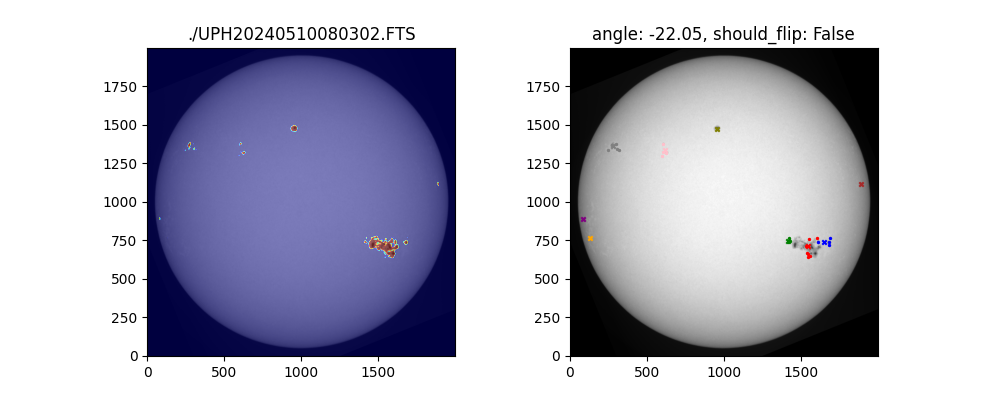

In [11]:

colors = [ "red", "green", "blue", "orange", "purple", "brown", "pink", "gray", "olive", "cyan", "magenta", "yellow"] 

fig3,ax3 = plt.subplots(1,2,figsize=(10,4))

ax3[0].clear(), ax3[1].clear()#, ax3[2].clear()
ax3[0].set_title(input_image)
ax3[0].imshow(m.data,cmap='gray')
ax3[0].imshow(seg,cmap='jet',alpha=0.5)
ax3[0].invert_yaxis()

ax3[1].imshow(m.data,cmap='gray')
ax3[1].invert_yaxis()

ax3[1].set_title(f'angle: {"%.2f" % clustering_dict["SOLAR_P0"]}, should_flip: {clustering_dict["should_flip"]}')
if clustering_dict['seg'] is not {}:
    
    ms_group_sunspots = clustering_dict['meanshift']['groups']
    ms_group_sunspots_px =  clustering_dict['meanshift']['groups_px']
    ms_centers = clustering_dict['meanshift']['centroids_px']
    
    for i in range(len(ms_group_sunspots)):
        c = colors[i%len(colors)]
        cur = np.array(ms_group_sunspots_px[i])
        cur_center = np.array(ms_centers[i])
        
        ax3[1].scatter(cur_center[0],cur_center[1], s=10, c=c, marker='x')
        ax3[1].scatter(cur[:,0], cur[:,1], color=c, s=2)

### Build a "dataset" from the groups found (to be used by classification model)

In [12]:
from sunscc.utils.clustering import matching_utilities as m_utils
from copy import deepcopy

def add_superclasses(group_dict):
    cpy = deepcopy(group_dict)    
    # print(cpy)

    cpy["SuperClass"] = {
        "1": "?",
        "2": "?",
        "3": "?",
    }
    
    return cpy

In [13]:

Rpx = h["SOLAR_R"]
# Rpx = 1480
bn , img_dict = m_utils.find_groups_one_image(wl_fn , seg_mask_fn,
                                            clustering_dict, 
                                            Rpx,
                                            input_type=input_type,
                                            
                                           )

groups = img_dict['groups']
group_based_dataset_superclasses = {}
for i, g in enumerate(groups):
    g['centroid_px'] = [g['centroid_px'][1],g['centroid_px'][0]]
    g['members'] = [[a[1],a[0]] for a in g['members']]
    g['members_mean_px'] = [g['members_mean_px'][1],g['members_mean_px'][0]]
    
    new_group_infos= {
        'angle': img_dict['angle'],
        'deltashapeX': img_dict['deltashapeX'],
        'deltashapeY':img_dict['deltashapeY'],
        'centroid_px': g['centroid_px'],
        'centroid_Lat': g['centroid_Lat'],
        'centroid_Lon': g['centroid_Lon'],
        'members': g['members'],
        'members_mean_px': g['members_mean_px'],
        'angular_excentricity_rad': g['angular_excentricity_rad'],
        'angular_excentricity_deg': g['angular_excentricity_deg'],
        'Zurich': g['Zurich'],
        'McIntosh': g['McIntosh'],   
    }

    new_goup_id = bn + '_' + str(i)
    
    group_based_dataset_superclasses[new_goup_id] = add_superclasses(new_group_infos)


In [14]:
from omegaconf import DictConfig, OmegaConf
from sunscc.dataset.transform.pipelines import Compose
from sunscc.dataset.utils import create_circular_mask, get_sun_mask

classification = 'SuperClass'

transforms_p1 = OmegaConf.load('../sunscc/conf/exp/Classification_Superclasses4.yaml').dataset.train_dataset.transforms
transforms_p1[3].standard_height = 350
transforms_p1[3].standard_width = 350

if isinstance(transforms_p1, collections.abc.Mapping):
    transforms_p1 = partial(call, config=transforms_p1)
elif isinstance(transforms_p1, collections.abc.Sequence):
    transforms_init = []
    for transform in transforms_p1:
        transforms_init.append(instantiate(transform))
    transforms = Compose(transforms_init)
    
classif_samples = {}

for index, (g_k, g_v) in tqdm(enumerate(group_based_dataset_superclasses.items())):
    group_dict = g_v
    basename = g_k.split('_')[0]
    
    sample = {} 
    
    basic_mask = create_circular_mask( image.shape[0], image.shape[1] ,center,radius=radius*1.03)
    sample['solar_disk'] = get_sun_mask( image.data, basic_mask, radius)
    
    sample['excentricity_map'] = create_excentricity_map(sample['solar_disk'], radius, value_outside=-1)
    sample['mask'] = io.imread(seg_mask_fn)
    sample['confidence_map'] = io.imread(seg_mask_fn)

    sample['image'] = (image.data).astype(float)

    sample['members'] = np.array(group_dict['members']) if 'members' in group_dict else np.array([0])
    sample['members_mean_px'] = np.array(group_dict['members_mean_px']) if 'members_mean_px' in group_dict else np.array([0])

    sample['name'] = basename
    sample['group_name'] = g_k

    sample['solar_angle'] = group_dict['angle']
    sample['deltashapeX'] = group_dict['deltashapeX']
    sample['deltashapeY'] = group_dict['deltashapeY']

    sample['angular_excentricity'] = np.array([group_dict["angular_excentricity_deg"]])
    sample['centroid_px'] = np.array(group_dict["centroid_px"])
    sample['centroid_Lat'] = np.array([group_dict["centroid_Lat"]])

    sample['class1'] = group_dict["SuperClass"]['1']
    sample['class2'] = group_dict["SuperClass"]['2']
    sample['class3'] = group_dict["SuperClass"]['3']
    
    if transforms is not None:
        sample = transforms(**sample)
        
    fig,ax = plt.subplots(1, 5, figsize=(10, 2) )
    ax[0].imshow(sample["image"], cmap='gray', interpolation='none')
    ax[0].set_title('Image')
    ax[1].imshow(sample["mask"], cmap='gray', interpolation='none', vmin=0, vmax=1)
    ax[0].set_title('mask')
    ax[2].imshow(sample["confidence_map"], cmap='gray', interpolation='none', vmin=0, vmax=1)
    ax[0].set_title('confidence_map')
    ax[3].imshow(sample["solar_disk"], cmap='gray', interpolation='none', vmin=0, vmax=1)
    ax[0].set_title('solar_disk')
    ax[4].imshow(sample["excentricity_map"], cmap='gray', interpolation='none', vmin=0, vmax=1)
    ax[0].set_title('excentricity_map')
    fig.tight_layout()
        
    center  = sample['image'].shape[0]//2 , sample['image'].shape[1]//2
    slice_x = center[0]-( 256 //2 ), center[0]+ (256 //2 )
    slice_y = center[1]-( 256 //2 ), center[1]+ (256 //2 )
    center_region = sample['confidence_map'][slice_x[0]:slice_x[1], slice_y[0]:slice_y[1]]
    if np.sum(center_region) == 0:
        print('skipping sample', index)
        sample = None
    
    if sample is not None:
        if sample['group_name'] not in classif_samples:
            classif_samples[sample['group_name']] = sample

    
    
    

0it [00:00, ?it/s]

# Classification
### Define path to Classification model and load it.

In [15]:
# classifier_run_dir = Path(os.environ['SUNSCCDATASET_PATH']+'/outputs/rebuttal/SUNSCC_AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run21')
classifier_run_dir = Path('/Volumes/WB_EXT_Niels/ROB_SEMINAR/Models/Classification/classif_run0')
classifier_ckpt_path = classifier_run_dir / 'models' / 'ENCODER_MLP1_MLP2_MLP3.ckpt'
print(classifier_run_dir)


/Volumes/WB_EXT_Niels/ROB_SEMINAR/Models/Classification/classif_run0


In [16]:
dataset_overrides = []
classif_config, classif_model, classif_dm, _ = load_from_dir2(
                                    run_path= classifier_run_dir.resolve(),
                                    # run_path= run_dir,
                                    model_path= classifier_ckpt_path.resolve(),
                                    load_trainer=False,
                                    override = dataset_overrides + [
                                        # Don't create new wandb run when testing/predicting
#                                         f'logger=[{{_target_: pytorch_lightning.loggers.CSVLogger, save_dir: "csv_metrics"}}]',
                                        f'logger=[]',
                                        '~callbacks.LR_monitor',
                                        '~callbacks.wandb',
                                    ]
                                )
# dm.setup()
test_dataloader = classif_dm.test_dataloader()

first_classes = classif_config.first_classes
second_classes = classif_config.second_classes
third_classes = classif_config.third_classes

c1_mapper = {c: i for i,c in enumerate(first_classes)}
c2_mapper = {c: i for i,c in enumerate(second_classes)}
c3_mapper = {c: i for i,c in enumerate(third_classes)}

Lightning automatically upgraded your loaded checkpoint from v1.6.0 to v2.2.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../Volumes/WB_EXT_Niels/ROB_SEMINAR/Models/Classification/classif_run0/models/ENCODER_MLP1_MLP2_MLP3.ckpt`


{'_target_': 'sunscc.model.McIntoshClassifier_Generic', 'input_format': {'visual': ['image', 'excentricity_map'], 'numeric': []}, 'output_format': ['class1', 'class2', 'class3'], 'classes': ['A', 'B', 'C', 'SuperGroup', 'H'], 'first_classes': ['A', 'B', 'C', 'SuperGroup', 'H'], 'second_classes': ['x', 'r', 'sym', 'asym'], 'third_classes': ['x', 'o', 'frag'], 'cascade': True, 'double_encoder': False, 'num_channels_offset': 0, 'architecture': {'encoder': {'type': 'new_resnet', 'resnet_version': 34, 'pretrained': True, 'in_channels': 2}, 'MLP1': [512, 256, 256, 128], 'MLP2': [512, 256, 256, 128], 'MLP3': [512, 256, 256, 128]}, 'focus_on_largest_sunspot': True, 'parts_to_train': ['MLP3']}
McIntoshClassifier_Generic
['image', 'excentricity_map'] ///// .  /////////
new_resnet 2 <class 'sunscc.model.NewResnet.ResBlock'> [3, 4, 6, 3]
in_feats 512
self.fc1_input_size 512
self.fc2_input_size 517
self.fc3_input_size 517
['MLP3']
encoder -> requires_grad = False
MLP1 -> requires_grad = False
MLP2 

### From the dataset of new sunspot groups, create a batch for classification model

In [17]:
transforms_p2 = OmegaConf.load(classifier_run_dir/'.hydra'/'config.yaml').dataset.test_dataset.transforms

if isinstance(transforms_p2, collections.abc.Mapping):
    transforms_p2 = partial(call, config=transforms_p2)
elif isinstance(transforms_p2, collections.abc.Sequence):
    transforms_init = []
    for transform in transforms_p2:
        transforms_init.append(instantiate(transform))
    transforms = Compose(transforms_init)

batch_v0 = classif_samples
batch_v1 = {}
if transforms is not None:
    for k, sample in batch_v0.items():
        sample = transforms(**sample)
        batch_v1[k] = sample

batch_keys = list(batch_v1.keys())
sample_keys = list(batch_v1[batch_keys[0]].keys())

keys_to_tensor = ['image', 'excentricity_map', 'solar_disk', 'mask', 'group_mask', 'confidence_map', 'group_confidence_map']

batch_v2 = {key: torch.tensor(np.concatenate([d[key][None,None,:,:] for d in batch_v1.values()])) 
            if key in keys_to_tensor else [d[key] for d in batch_v1.values()] 
            for key in sample_keys}

### Predict and show McIntosh classification

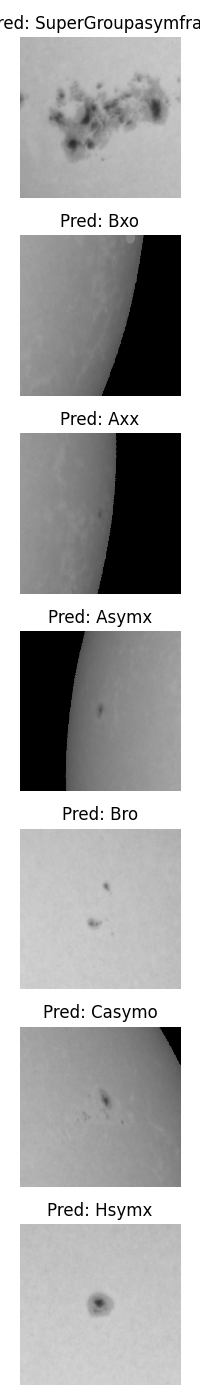

In [18]:
classif_batch = batch_v2

output_classif = classif_model.predict(classif_batch)
# print(output_classif)
display_classification_predictions(classif_batch, output_classif, c1_mapper,c2_mapper,c3_mapper)
# print(output_classif)